In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/02


In [2]:
def fit(nsamples,nbins,start): #define starting index
    cols=[f'toybin{i:04d}' for i in range(start,start+nbins)]
    diagnostics_df=pd.DataFrame(columns=cols,index=['sigma_median','mcse','rhat'])
    sigma_df=pd.DataFrame(columns=cols)
    sigma_2pi0_df=pd.DataFrame(columns=cols)
    for i in range(start,start+nbins):#no. of toy bins
        print(f"Fitting toy MC bin no.{i}")
        #read data
        df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
        df_2pi0=pd.read_csv(f"toybins/2pi0bin.txt",sep='\t')
        #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
        df.columns=['pol','phi','weight']
        df_2pi0.columns=['sigma','dsigma','f_s','f_b']
        #these are prompt peak events
        prmpt=df.loc[df['weight']==1]
        prmpt=prmpt.reset_index(drop=True)
        #sideband
        side=df.loc[df['weight']!=1]
        side=side.reset_index(drop=True)
        nprmpt=len(prmpt)
        total_nside=(len(side))
        #weights used in the data, including 1--> exterminate 1
        weights=pd.unique(df['weight'].values)
        weights=np.array(weights[weights!=1])
        #sideband events are identified by the corresponding weights
        nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
        #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
        f=(nprmpt+np.sum(nside*weights))/nprmpt
        print(f)
        stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f, #fraction of signal in prmpt peak
            'f_s': df_2pi0['f_s'].values[0], #fraction of etap events
            'f_b': df_2pi0['f_b'].values[0], #fraction of 2pi0 events
            'sigma_2pi0_meas': df_2pi0['sigma'].values[0],#measured value of sigma_2pi0 
            'dsigma_2pi0_meas': df_2pi0['dsigma'].values[0] #w/ stat error
        }
        print(nprmpt, total_nside)
        #now the stan model and mcmc
        model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
        model.compile()
        fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0,output_dir='./stan_trash',show_progress=True)
        summary=fitobj.summary()
        samples=fitobj.draws_pd()
        #get mcmc diagnostics
        median=summary['50%']['sigma']
        mcse=(az.mcse(np.transpose(fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        rhat=(summary['R_hat']['sigma'])
        tmp_list=[median,mcse,rhat]
        currbin=f"toybin{i:04d}"
        diagnostics_df[currbin]=tmp_list
        sigma_df[currbin]=samples['sigma']
        sigma_2pi0_df[currbin]=samples['sigma_2pi0']
    return diagnostics_df, sigma_df, sigma_2pi0_df, summary

def fit_bin(nsamples,binnr): #fit only one bin
    #read data
    df=pd.read_csv(f"toybins/toybin{binnr:04d}.txt",sep="\t")
    df.columns=['pol','phi','weight']
    df_2pi0=pd.read_csv(f"toybins/2pi0bin.txt",sep='\t')
    df_2pi0.columns=['sigma','dsigma','f_s','f_b']


    #these are prompt peak events
    prmpt=df.loc[df['weight']==1]
    prmpt=prmpt.reset_index(drop=True)
    #sideband
    side=df.loc[df['weight']!=1]
    side=side.reset_index(drop=True)
    nprmpt=len(prmpt)
    total_nside=(len(side))
    #weights used in the data, including 1--> exterminate 1
    weights=pd.unique(df['weight'].values)
    weights=np.array(weights[weights!=1])
    #sideband events are identified by the corresponding weights
    nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
    #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
    f=(nprmpt+np.sum(nside*weights))/nprmpt
    print(f)
    stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f, #fraction of signal in prmpt peak
            'f_s': df_2pi0['f_s'].values[0], #fraction of etap events
            'f_b': df_2pi0['f_b'].values[0], #fraction of 2pi0 events
            'sigma_2pi0_meas': df_2pi0['sigma'].values[0],#measured value of sigma_2pi0 
            'dsigma_2pi0_meas': df_2pi0['dsigma'].values[0] #w/ stat error
        }
    print(nprmpt, total_nside)
    #now the stan model and mcmc
    model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
    model.compile()
    fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0)
    summary=fitobj.summary()
    samples=fitobj.draws_pd()
    return samples,summary

In [3]:
#dfs=fit(nsamples=5000,nbins=1,start=999)
#diagnostics=dfs[0]
#sigma=dfs[1]
#diagnostics.to_csv('toy_diagnostics.csv')
#sigma.to_csv('toy_sigma.csv')


In [5]:
dfs[2]

Mean     MCSE  StdDev     5%     50%     95%     N_Eff  N_Eff/s  \
name                                                                           
lp__      -1.8000  0.03500   3.000 -7.300 -1.5000  2.5000   7500.00   100.00   
sigma      0.1700  0.00120   0.240 -0.230  0.1700  0.5700  38000.00   520.00   
a[1]       0.0063  0.00029   0.060 -0.093  0.0065  0.1100  43165.00   585.00   
a[2]      -0.0820  0.00029   0.061 -0.180 -0.0820  0.0200  42579.00   577.00   
a[3]      -0.0170  0.00032   0.061 -0.120 -0.0170  0.0830  36086.00   489.00   
a[4]       0.0540  0.00030   0.061 -0.047  0.0530  0.1500  41047.00   556.00   
b[1]      -0.0490  0.00032   0.060 -0.150 -0.0490  0.0500  35511.00   481.00   
b[2]      -0.0300  0.00031   0.061 -0.130 -0.0290  0.0700  39514.00   536.00   
b[3]      -0.0750  0.00030   0.060 -0.170 -0.0750  0.0240  40307.00   546.00   
b[4]      -0.0770  0.00032   0.061 -0.180 -0.0770  0.0240  36472.00   494.00   
sigma_bkg -0.5300  0.00000   0.240 -0.900 -0.5400 -0.1000  31738.48   430.13   
a_bkg[1]   0.0820  0.00031   0.062 -0.021  0.0820  0.1800  39633.00   537.00   
a_bkg[2]   0.0089  0.00032   0.064 -0.097  0.0088  0.1200  39665.00   538.00   
a_bkg[3]  -0.0390  0.00030   0.062 -0.140 -0.0390  0.0620  42569.00   577.00   
a_bkg[4]  -0.1000  0.00030   0.064 -0.210 -0.1000  0.0042  44150.00   598.00   
b_bkg[1]  -0.0230  0.00032   0.063 -0.130 -0.0220  0.0800  38239.00   518.00   
b_bkg[2]   0.0380  0.00033   0.064 -0.066  0.0380  0.1400  36767.00   498.00   
b_bkg[3]   0.0140  0.00032   0.063 -0.091  0.0140  0.1200  38330.00   519.00   
b_bkg[4]   0.0200  0.00032   0.062 -0.084  0.0200  0.1200  39025.00   529.00   

           R_hat  
name              
lp__         1.0  
sigma        1.0  
a[1]         1.0  
a[2]         1.0  
a[3]         1.0  
a[4]         1.0  
b[1]         1.0  
b[2]         1.0  
b[3]         1.0  
b[4]         1.0  
sigma_bkg    1.0  
a_bkg[1]     1.0  
a_bkg[2]     1.0  
a_bkg[3]     1.0  
a_bkg[4]     1.0  
b_bkg[1]     1.0  
b_bkg[2]     1.0  
b_bkg[3]     1.0  
b_bkg[4]     1.0

In [4]:
sigma_df=pd.read_csv('toy_sigma.csv',index_col=0)
sigma_2pi0_df=pd.read_csv('toy_sigma2pi0.csv',index_col=0)
diagnostics_df=pd.read_csv('toy_diagnostics.csv',index_col=0)

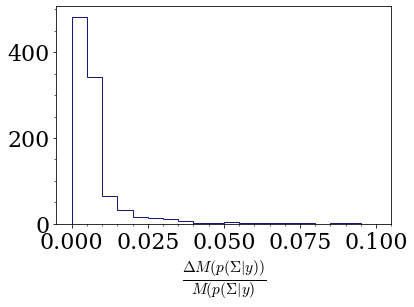

In [47]:
rel_err=np.array([(diagnostics_df[f'toybin{i:04d}']['mcse']/np.abs(diagnostics_df[f'toybin{i:04d}']['sigma_median'])) for i in range(len(diagnostics_df.columns))])
plt.hist(rel_err,histtype='step',color='midnightblue',bins=20,range=[0,0.1])
plt.xlabel('$\\frac{\Delta M(p(\Sigma|y))}{M(p(\Sigma|y)}$')
plt.grid(False)
plt.savefig('./plots/toyMC_mcse_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()


In [17]:
all_sigmas=[]
for i in range(len(sigma_df.columns)):
    all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)))
    #all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)-0.5)/np.std(sigma_df[f'toybin{i:04d}'].values))

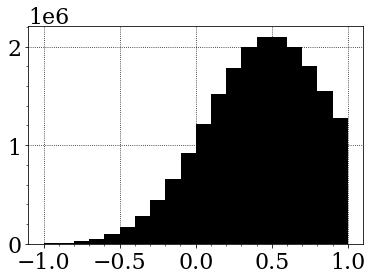

In [18]:
plt.hist(all_sigmas,bins=20)
plt.show()

In [18]:
h=r.TH1D("h","h",100,-1,1)
for i in range(len(all_sigmas)):
    h.Fill(all_sigmas[i])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [19]:
c=r.TCanvas("c","c")
c.Draw("")
c.SetBottomMargin(0.15)
h.Draw("")
h.GetXaxis().SetLabelFont(132)
h.GetYaxis().SetLabelFont(132)
h.GetYaxis().SetTitle("#font[132]{p(#Sigma|D_{#it{i}})}")
#h.GetXaxis().SetTitle("#font[132]{#frac{p(#Sigma|D_{#it{i}})-#Sigma_{true}}{std(p(#Sigma|D_{#it{i}}))}}")
h.GetXaxis().SetTitle("#font[132]{#Sigma}")
h.SetTitle("")
h.GetYaxis().SetNdivisions(0)
h.GetYaxis().SetLabelSize(0)
r.gStyle.SetOptStat(0)
h.GetXaxis().SetTitleOffset(1.5)
f=r.TF1("f","gaus",-2,2)
h.Fit(f,"SN","",-1,1)
f.Draw("Same")
t=r.TLatex()
t.SetTextAlign(22)
mu = f.GetParameter(1)
mu_err = f.GetParError(1)
sigma=f.GetParameter(2)
sigma_err=f.GetParError(2)
t.DrawLatex(0,5e3,f"#color[2]{{#font[132]{{#mu={mu:.4f}#pm{mu_err:.4f}, #sigma={sigma:.4f}#pm{sigma_err:.4f}}}}}")

 FCN=3244.74 FROM MIGRAD    STATUS=CONVERGED      80 CALLS          81 TOTAL
                     EDM=9.79967e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.27608e+05   1.14397e+02   2.65970e+00   2.14233e-06
   2  Mean         5.07083e-01   1.54104e-04   3.10598e-06   6.27755e+00
   3  Sigma        4.25785e-01   1.09952e-04   1.70273e-06  -1.72094e+01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [20]:
c.SaveAs("./plots/combined_post_add_raw.pdf")
c.SaveAs("./plots/combined_post_add_raw.root")

Info in <TCanvas::Print>: pdf file ./plots/combined_post_add_raw.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file ./plots/combined_post_add_raw.root has been created


In [5]:
all_2pi0sigmas=[]
for i in range(len(sigma_2pi0_df.columns)):
    all_2pi0sigmas.extend((np.array(sigma_2pi0_df[f'toybin{i:04d}'].values)))
    #all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)-0.5)/np.std(sigma_df[f'toybin{i:04d}'].values))

In [10]:
h=r.TH1D("h","h",100,-1,1)
for i in range(len(all_2pi0sigmas)):
    h.Fill(all_2pi0sigmas[i])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [14]:
c=r.TCanvas("c","c")
c.Draw("")
c.SetBottomMargin(0.15)
h.Draw("")
h.GetXaxis().SetLabelFont(132)
h.GetYaxis().SetLabelFont(132)
h.GetYaxis().SetTitle("#font[132]{p(#Sigma_{2#pi^{0}}|D_{#it{i}})}")
#h.GetXaxis().SetTitle("#font[132]{#frac{p(#Sigma|D_{#it{i}})-#Sigma_{true}}{std(p(#Sigma|D_{#it{i}}))}}")
h.GetXaxis().SetTitle("#font[132]{#Sigma_{2#pi^{0}}}")
h.SetTitle("")
h.GetYaxis().SetNdivisions(0)
h.GetYaxis().SetLabelSize(0)
r.gStyle.SetOptStat(0)
h.GetXaxis().SetTitleOffset(1.5)
f=r.TF1("f","gaus",-2,2)
h.Fit(f,"SN","",-1,1)
f.Draw("Same")
t=r.TLatex()
t.SetTextAlign(22)
mu = f.GetParameter(1)
mu_err = f.GetParError(1)
sigma=f.GetParameter(2)
sigma_err=f.GetParError(2)
t.DrawLatex(0,5e3,f"#color[2]{{#font[132]{{#mu={mu:.5f}#pm{mu_err:.5f}, #sigma={sigma:.5f}#pm{sigma_err:.5f}}}}}")

 FCN=12.2885 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=1.30798e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.17030e+06   8.68526e+02   1.51172e+00   7.15321e-07
   2  Mean        -3.00008e-01   1.12552e-05   1.43055e-07   9.21193e-01
   3  Sigma        5.03349e-02   7.96695e-06   4.42169e-07   8.05313e+00


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [15]:
c.SaveAs("./plots/combined2pi0_post_add_raw.pdf")
c.SaveAs("./plots/combined2pi0_post_add_raw.root")

Info in <TCanvas::Print>: pdf file ./plots/combined2pi0_post_add_raw.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file ./plots/combined2pi0_post_add_raw.root has been created


In [39]:
fit=fit_bin(nsamples=1000,binnr=11)
samples=fit[0]
summary=fit[1]

0.9496291560102302
391 303


INFO:cmdstanpy:compiling stan file /Users/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/toyMC_stan.stan to exe file /Users/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/toyMC_stan
INFO:cmdstanpy:compiled model executable: /Users/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/toyMC_stan
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


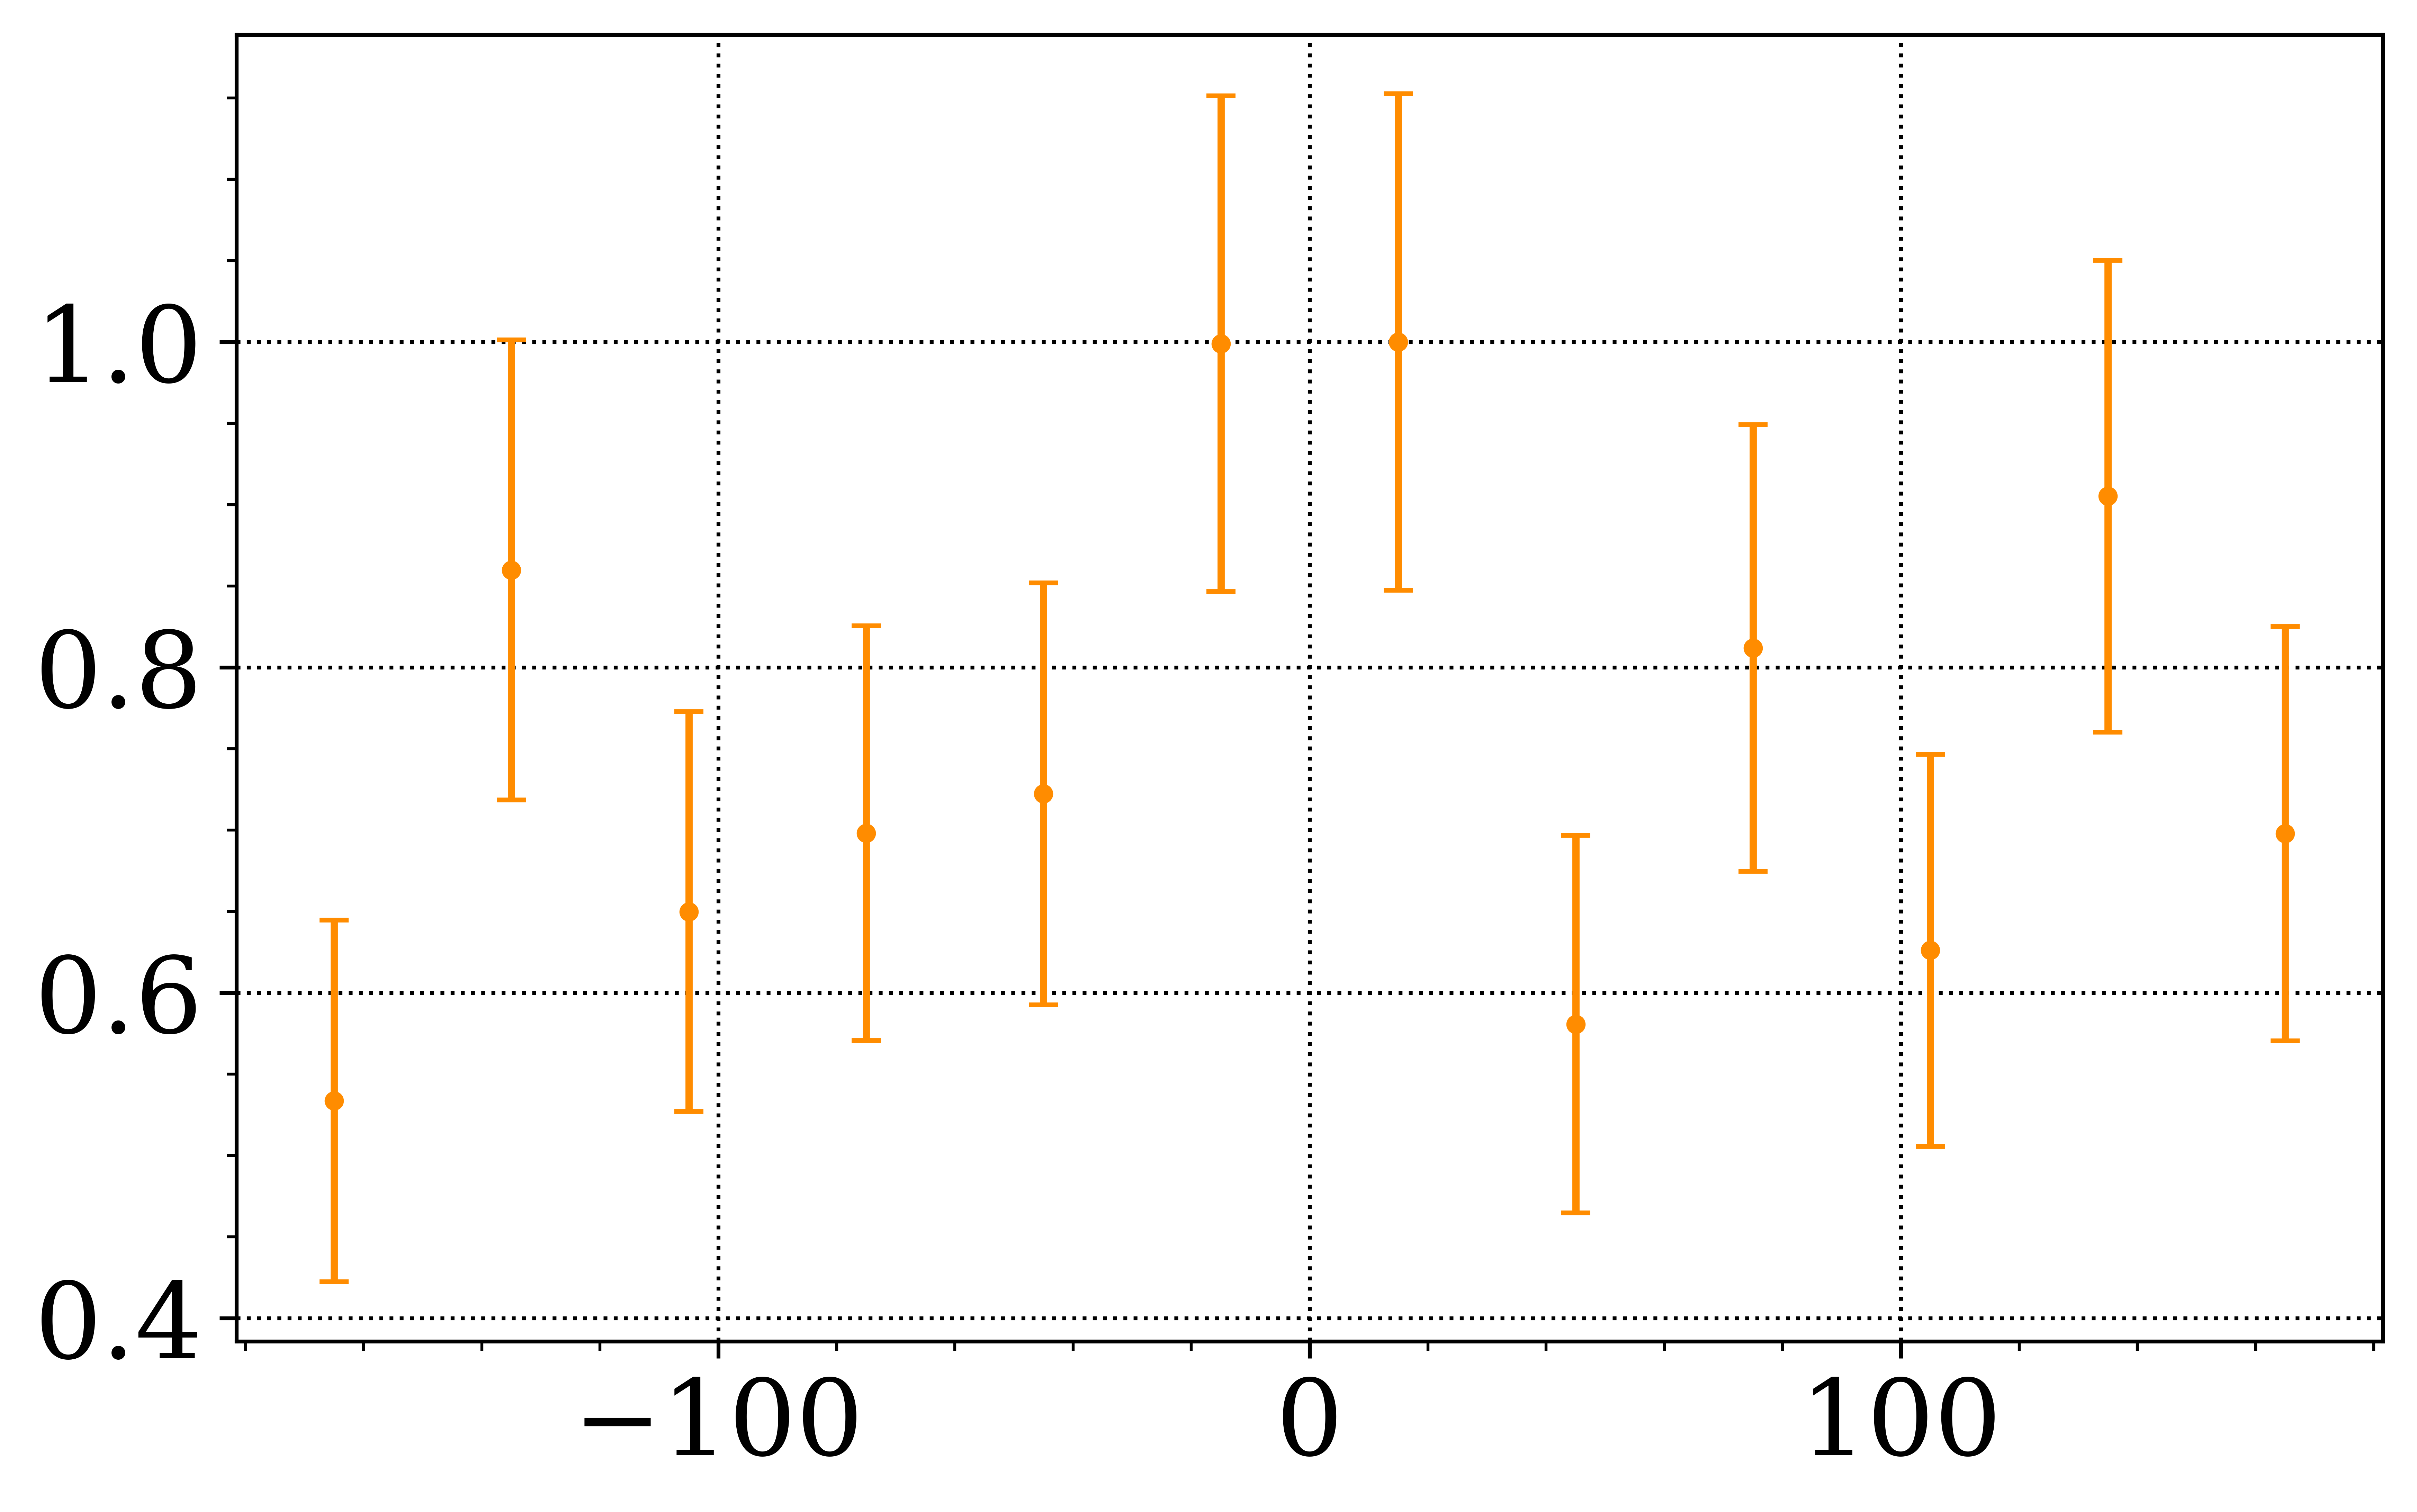

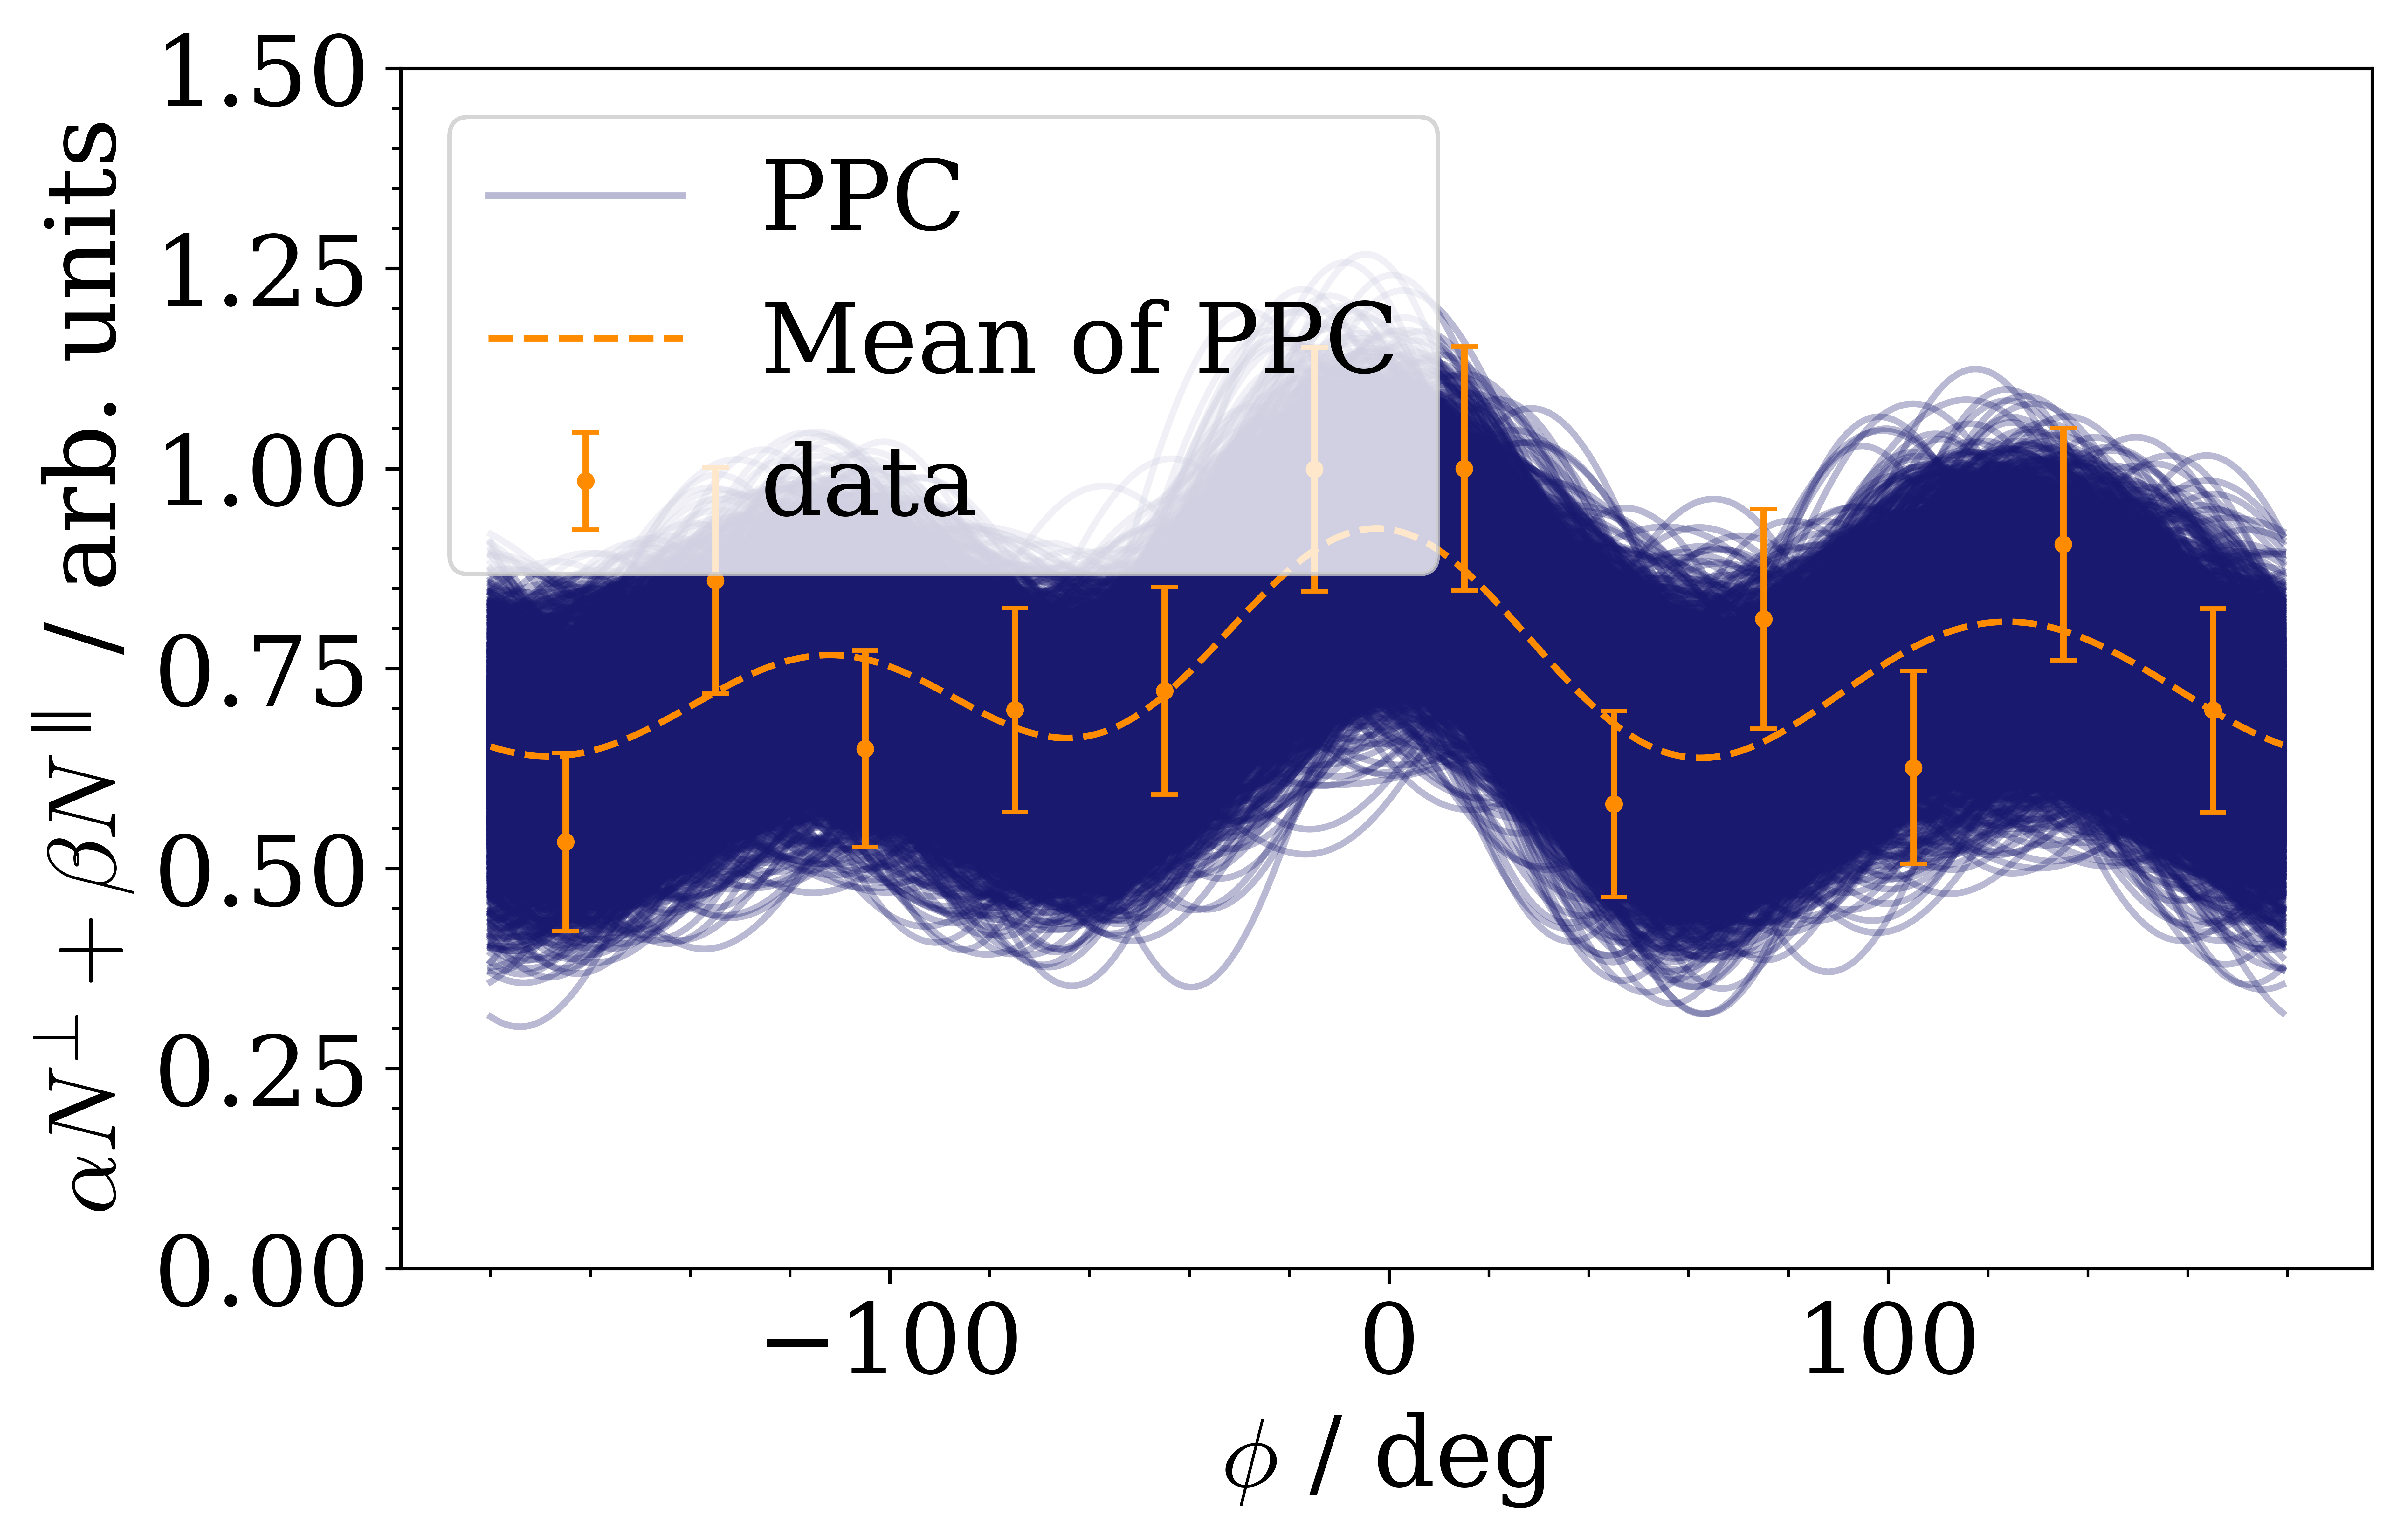

Warning in <TROOT::Append>: Replacing existing TH1: p45 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: m45 (Potential memory leak).


In [44]:
#read data
i=11 # define which bin to use
df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
df.columns=['pol','phi','weight']
#select only prmpt events
p45=df.loc[(df['weight']==1)&(df['pol']>0)].reset_index(drop=True)
m45=df.loc[(df['weight']==1)&(df['pol']<0)].reset_index(drop=True)
hp45=r.TH1F("p45","p45",12,-180,180)
hm45=r.TH1F("m45","m45",12,-180,180)
#histogram them
for i in p45['phi'].values:
    hp45.Fill(i)
for i in m45['phi'].values:
    hm45.Fill(i)
#normalize    
norm_p = 1./hp45.Integral()
norm_m = 1./hm45.Integral()
hp45.Scale(norm_p)
hm45.Scale(norm_m)

#build polarization weighted sum
pol_p45=np.abs(np.mean(p45['pol']))
pol_m45=np.abs(np.mean(m45['pol']))
hp45.Add(hp45,hm45,pol_m45/(pol_p45+pol_m45),pol_p45/(pol_m45+pol_p45))
hp45.Scale(1./hp45.GetMaximum())


#write values of histo to numpy array
asym=[]
asym_err=[]
phi=[]
for i in range(hp45.GetNbinsX()):
    asym.append(hp45.GetBinContent(i+1))
    asym_err.append(hp45.GetBinError(i+1))
    phi.append(hp45.GetBinCenter(i+1))
asym=np.array(asym)
asym_err=np.array(asym_err)
phi=np.array(phi)
xx=np.arange(-180,180)

#plot results
fig, ax = plt.subplots(figsize=(8,5),dpi=1000)
ax.errorbar(x=phi,y=asym,yerr=asym_err,fmt='.',color='darkorange',zorder=3,label='data')
#get ALL values of fourier coeff
eff_list=[]
for i in range(4000):
    #get mean values of fourier coeff
    tmp_a=[samples[f'a[{j+1}]'][i] for j in range(4)]
    tmp_b=[samples[f'b[{j+1}]'][i] for j in range(4)]
    #put them in efficiency function
    def tmp_eff(x,c):
        val=1 # a0=0,b0=1
        for i in range(4):
            val+=tmp_a[i]*np.sin((i+1)*x*np.pi/180)+tmp_b[i]*np.cos((i+1)*x*np.pi/180)
        return c*val 
    popt,pcov = curve_fit(tmp_eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
    eff_list.append(tmp_eff(xx,popt))
    #ax.plot(xx,eff(xx,popt),color='midnightblue',alpha=0.5)
for i in range(4000):
    if(i==0):
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.3,label='PPC')
    else:
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.3)
#get mean values of fourier coeff
a=[summary['Mean'][f'a[{i+1}]'] for i in range(4)]
b=[summary['Mean'][f'b[{i+1}]'] for i in range(4)]
#put them in efficiency function
def eff(x,c):
    val=1 # a0=0,b0=1
    for i in range(4):
        val+=a[i]*np.sin((i+1)*x*np.pi/180)+b[i]*np.cos((i+1)*x*np.pi/180)
    return c*val 
popt,pcov = curve_fit(eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
ax.plot(xx,eff(xx,popt),color='darkorange',ls='--',label='Mean of PPC')

    
    

ax.set_ylim([0,1.5])
ax.set_xlabel("$\phi$ / deg")
ax.set_ylabel(r"$\alpha N^{\bot} + \beta N^{\parallel} $ / arb. units")
ax.grid(False)
plt.legend()
plt.show()

In [45]:
fig.savefig('./plots/toyMC_eff_PPC.pdf',format='pdf',dpi=1000,bbox_inches='tight')